In [4]:
import os
import glob 
import re
import numpy as np
import matplotlib.pyplot as plt
import register as rfn
import ants
import shutil
import scipy.misc
from scipy import ndimage
import math
import admin_functions1 as adfn
from skimage import io
import pandas as pd
import seaborn as sns
plt.style.use('default')

%load_ext autoreload
%autoreload

# Define paths
#---------------------------------------------------------------------------
Fdrop = '/Users/dominicburrows/Dropbox/PhD/analysis/'
Fmac = '/Users/dominicburrows/Documents/'
F10t = '/Volumes/Dominic 10tb/'
F10t2 = '/Volumes/Dominic 10tb2/'
Ffig = '/Users/dominicburrows/Dropbox/PhD/figures/'
Ftm = '/Volumes/Dominic Time Machine/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Load zebrafish brain browser images and format 
#-----------------------------------------------------------------------------------
Fzbb = Fdrop + '/' + 'zbrain_stacks/'
zbb1 = ants.image_read(Fzbb + os.sep + 'Misc/huC-h2b-RFP.tif')     
zbb1.set_spacing([.3,.3,1.])
zbb  = (zbb1 / np.amax(zbb1.numpy()))
zbb.set_spacing([.3,.3,1.])

# Load genetic atlas labels and format (already in zbb space)
#-----------------------------------------------------------------------------------
Fzbb = Fdrop + 'zbrain_stacks/'
atlasim = Fzbb + 'atlas/pajevic1.tif'
atlasli = Fzbb + 'atlas/Pajevic_annotations.csv'
atlaslab=pd.read_csv(atlasli, sep=',',header=None)
label = ants.image_read(atlasim)
label.set_spacing([1.2,1.2,4.])


# Load kunst
#-----------------------------------------------------------------------------------
kb = ants.image_read(Fzbb + os.sep + 'kunst/T_AVG_H2BGCaMP_H2BGCaMP.tif') 
kb.set_direction(np.array([[0,1.,0.],[1.,0.,0.],[0.,0.,-1.]])) 
kb.set_spacing([.3,.3,1])

In [6]:
# Create datalists
#---------------------------------------------------------------------------
experiment = 'PTZ-WILDTYPE'
os.chdir(Fdrop + 'Project/' + experiment)
conn_list = sorted(glob.glob('*atlas*')) 
kmeans_list = sorted(glob.glob('*Ahrens*'))
conn_list, kmeans_list

import pandas as pd
coords = pd.read_csv(conn_list[0])
coords

ID     start_x     start_y     start_z      stop_x      stop_y  \
0         1  419.605743  372.904877  208.815018  405.110321  352.853363   
1         1  419.605743  372.904877  208.815018  401.367859  341.110229   
2         1  419.605743  372.904877  208.815018  401.930298  335.409088   
3         1  419.605743  372.904877  208.815018  411.859863  343.718719   
4         1  419.605743  372.904877  208.815018  419.022858  348.411011   
...     ...         ...         ...         ...         ...         ...   
81277  3119  260.879578  234.483383  106.049133  229.904556  214.334442   
81278  3119  260.879578  234.483383  106.049133  238.541321  210.633423   
81279  3119  260.879578  234.483383  106.049133  243.640427  223.822769   
81280  3119  260.879578  234.483383  106.049133  217.230270  240.188019   
81281  3119  260.879578  234.483383  106.049133  223.145920  245.975769   

           stop_z  
0      197.227615  
1      212.254959  
2      213.875122  
3      214.643921  
4      217.191559  
...           ...  
81277  110.568687  
81278   82.402649  
81279   98.493629  
81280   95.431923  
81281  100.079201  

[81282 rows x 7 columns]

# Pre-process image

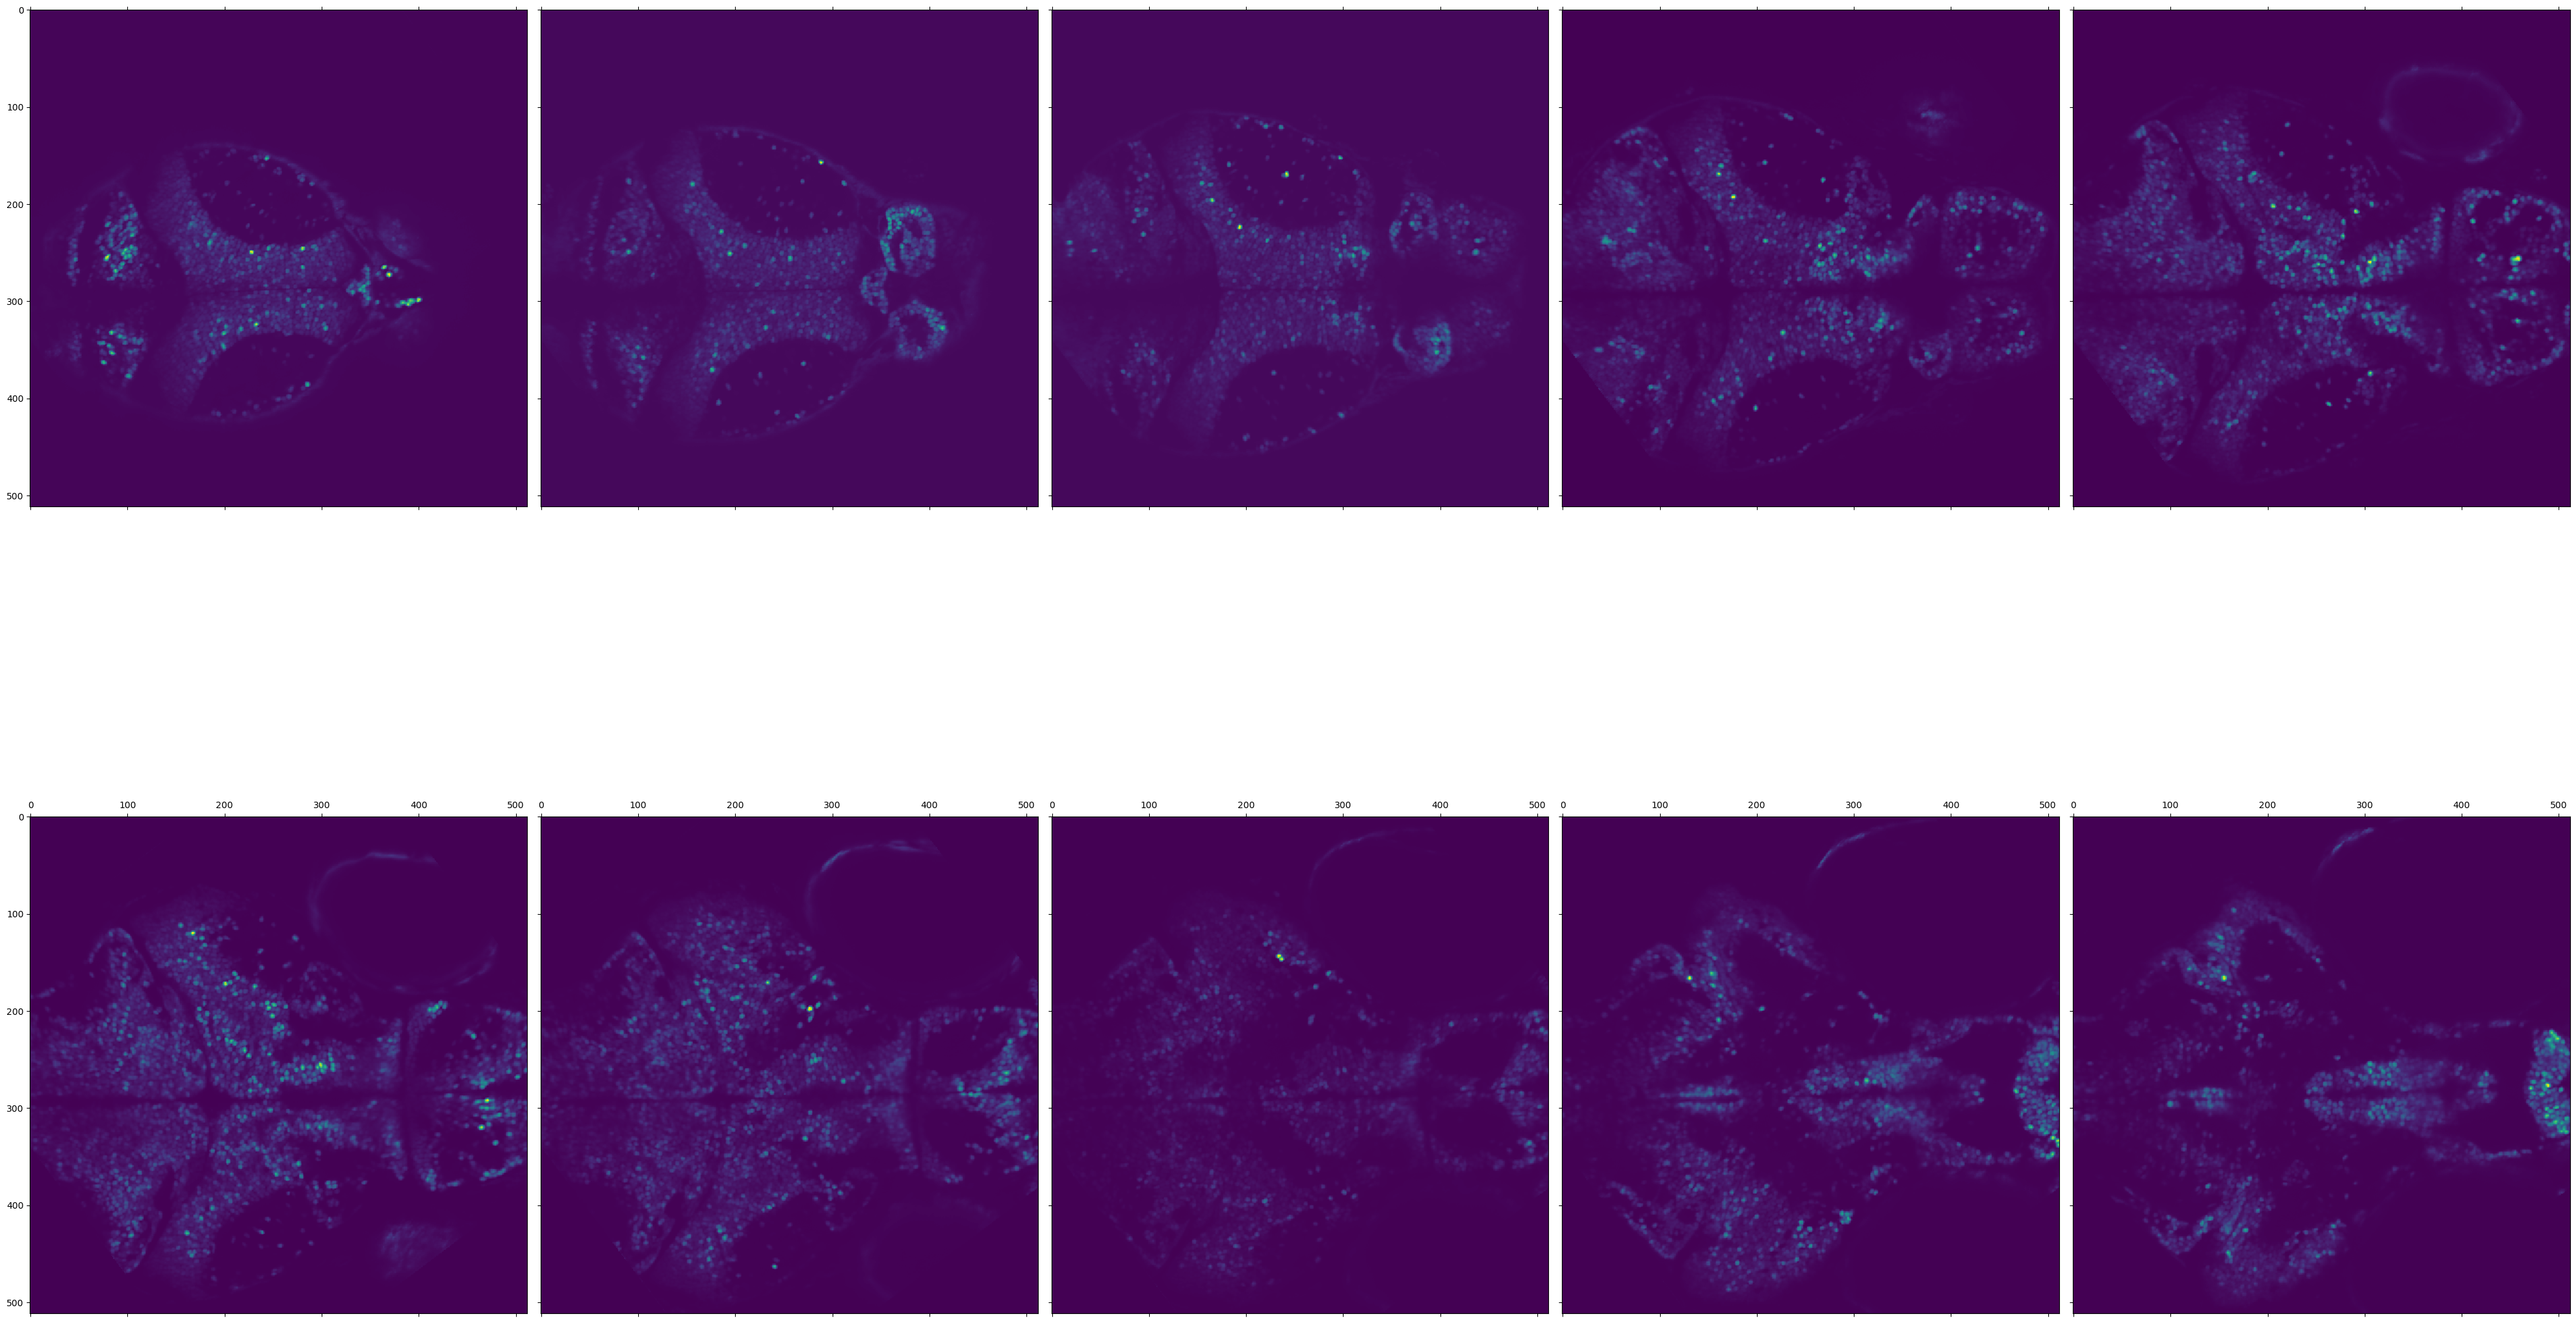

In [52]:
# Choose fish and make opslist (list of planes to stack together) 
#----------------------------------------------------------------
experiment = 'BLNLIGHTPTZ-FOXG1---05'
condition = 'PTZ02_' #BE SURE TO ADD _ AT END
Freg = F10t2 + 'Project/' + experiment + '/2photon/sess-01-6dpf/'
os.chdir(Freg)
opslist = sorted(glob.glob('*' + condition + '*ops.npy'))

# Rotate image - select correct orientation for registration
#----------------------------------------------------------------
degree=217
Frotate = rfn.rotate(Freg, opslist, degree)

In [53]:
# Save as multipage tif - for registration
#-----------------------------------------
Frotate_save = rfn.savemeanimg(Freg, opslist, Frotate, degree)

## Batch process

In [ ]:
experiment = 'BLNLIGHTPTZ-FOXG1'
savepath = Fdrop + 'Project/' + experiment + os.sep 

num1 = adfn.name_zero('front', 5, 6, 1)
typelist = ['BLNLIGHT_', 'PTZ02_'] #ADD _ AT END
pref = '---' #ADD - AT END


for i in num1:
    num = i
    for e in typelist:
        condition = e

        Freg = F10t2 + 'Project/' + experiment + pref + num + '/2photon/sess-01-6dpf/'
        os.chdir(Freg)
        meanimglist = sorted(glob.glob('*' + condition + '*meanimgstack*'))

        #Find files
        #--------------------------------------------------------
        os.chdir(Fdrop + 'Project/' + experiment)
        coordlist = sorted(glob.glob('*' + pref + num + '*' + condition + '*realcoord.npy'))
        tracelist = sorted(glob.glob('*' + pref + num + '*' + condition + '*_realtrace.npy'))
        binlist = sorted(glob.glob('*' + pref + num + '*' + condition + '*_binarised.npy'))
        dfflist = sorted(glob.glob('*' + pref + num + '*' + condition + '*_deltaff.npy'))
        print('Doing ' + coordlist[0])
        # Visualise fish
        #---------------------------------------------------------------------------
        f = ants.image_read(Freg + os.sep + meanimglist[0])
        f.set_spacing([.3, .3, 15.])
        f.set_direction(np.array([[-1.,0.,0.],[0.,1.,0.],[0.,0.,1.]])) 
        ants.plot(f, axis = 2, nslices = 5, slices = np.arange(0, 5, 1), figsize = 10)
        
        fixed = zbb
        moving = f
        coord = np.load(coordlist[0])
        trace = np.load(tracelist[0])
        dff = np.load(dfflist[0])
        bind = np.load(binlist[0])
        reg_type = 'SyNRA'
        mode = 'check'
        fin_coord, lab_coord, fin_trace, fin_bind, fin_dff = rfn.reg_label(fixed, moving, label, atlaslab, coord, trace, dff, bind, meanimglist, reg_type, mode)
        np.save(savepath + adfn.name_template(coordlist, 'short') + '_regcoord.npy', fin_coord)
        np.save(savepath + adfn.name_template(coordlist, 'short') + '_labcoord.npy', lab_coord)
        np.save(savepath + adfn.name_template(coordlist, 'short') + '_regtrace.npy', fin_trace)
        np.save(savepath + adfn.name_template(coordlist, 'short') + '_regbinarised.npy', fin_bind)
        np.save(savepath + adfn.name_template(coordlist, 'short') + '_regdeltaff.npy', fin_dff)
        print('Done' + coordlist[0])

# Register to atlas

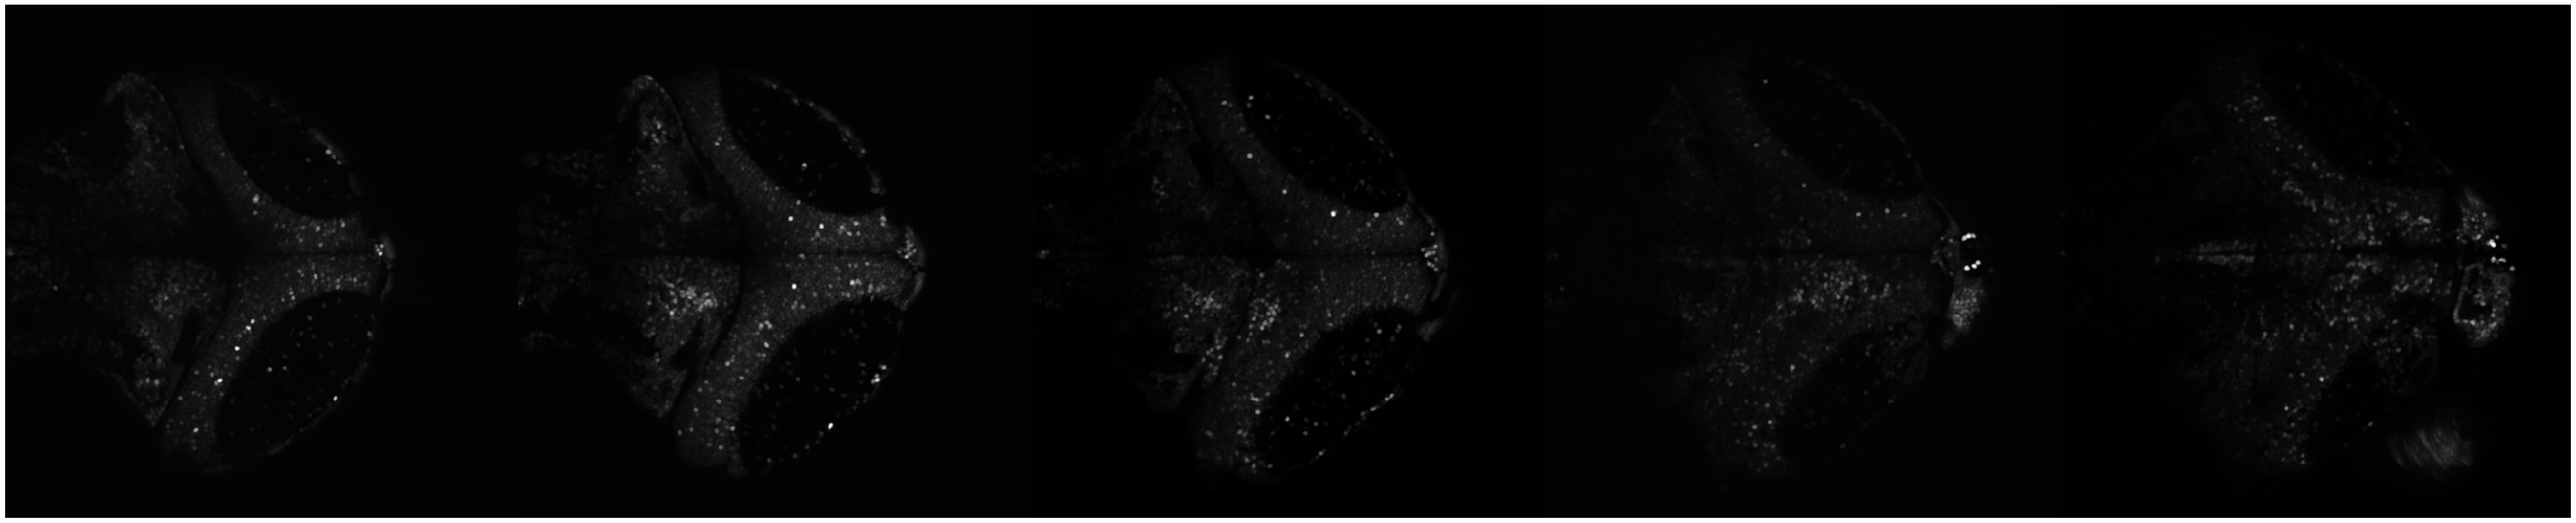

In [257]:
# Define fish name
#----------------------------------------------------------------
experiment = 'PTZ-WILDTYPE'
num = '02'
condition = 'BLN'

#Find fish image
#--------------------------------------------------------
Freg = Ftm + 'Project/' + experiment + '-' + num + '/2photon/sess-01-6dpf/'
os.chdir(Freg)
meanimglist = sorted(glob.glob('*' + condition + '*meanimgstack*'))

#Find coordinates
#--------------------------------------------------------
os.chdir(Fdrop + 'Project/' + experiment)
coordlist = sorted(glob.glob('*-' + num + '*' + condition + '*realcoord.npy'))
tracelist = sorted(glob.glob('*-' + num + '*' + condition + '*_realtrace.npy'))
binlist = sorted(glob.glob('*-' + num + '*' + condition + '*_binarised.npy'))
dfflist = sorted(glob.glob('*-' + num + '*' + condition + '*_deltaff.npy'))

# Visualise fish
#---------------------------------------------------------------------------
f = ants.image_read(Freg + os.sep + meanimglist[0])
f.set_spacing([.3, .3, 15.])
f.set_direction(np.array([[-1.,0.,0.],[0.,1.,0.],[0.,0.,1.]])) 
ants.plot(f, axis = 2, nslices = 5, slices = np.arange(0, 5, 1), figsize = 10)

In [5]:
f_prac = ants.registration(zbb, f, type_of_transform = 'SyNRA') 

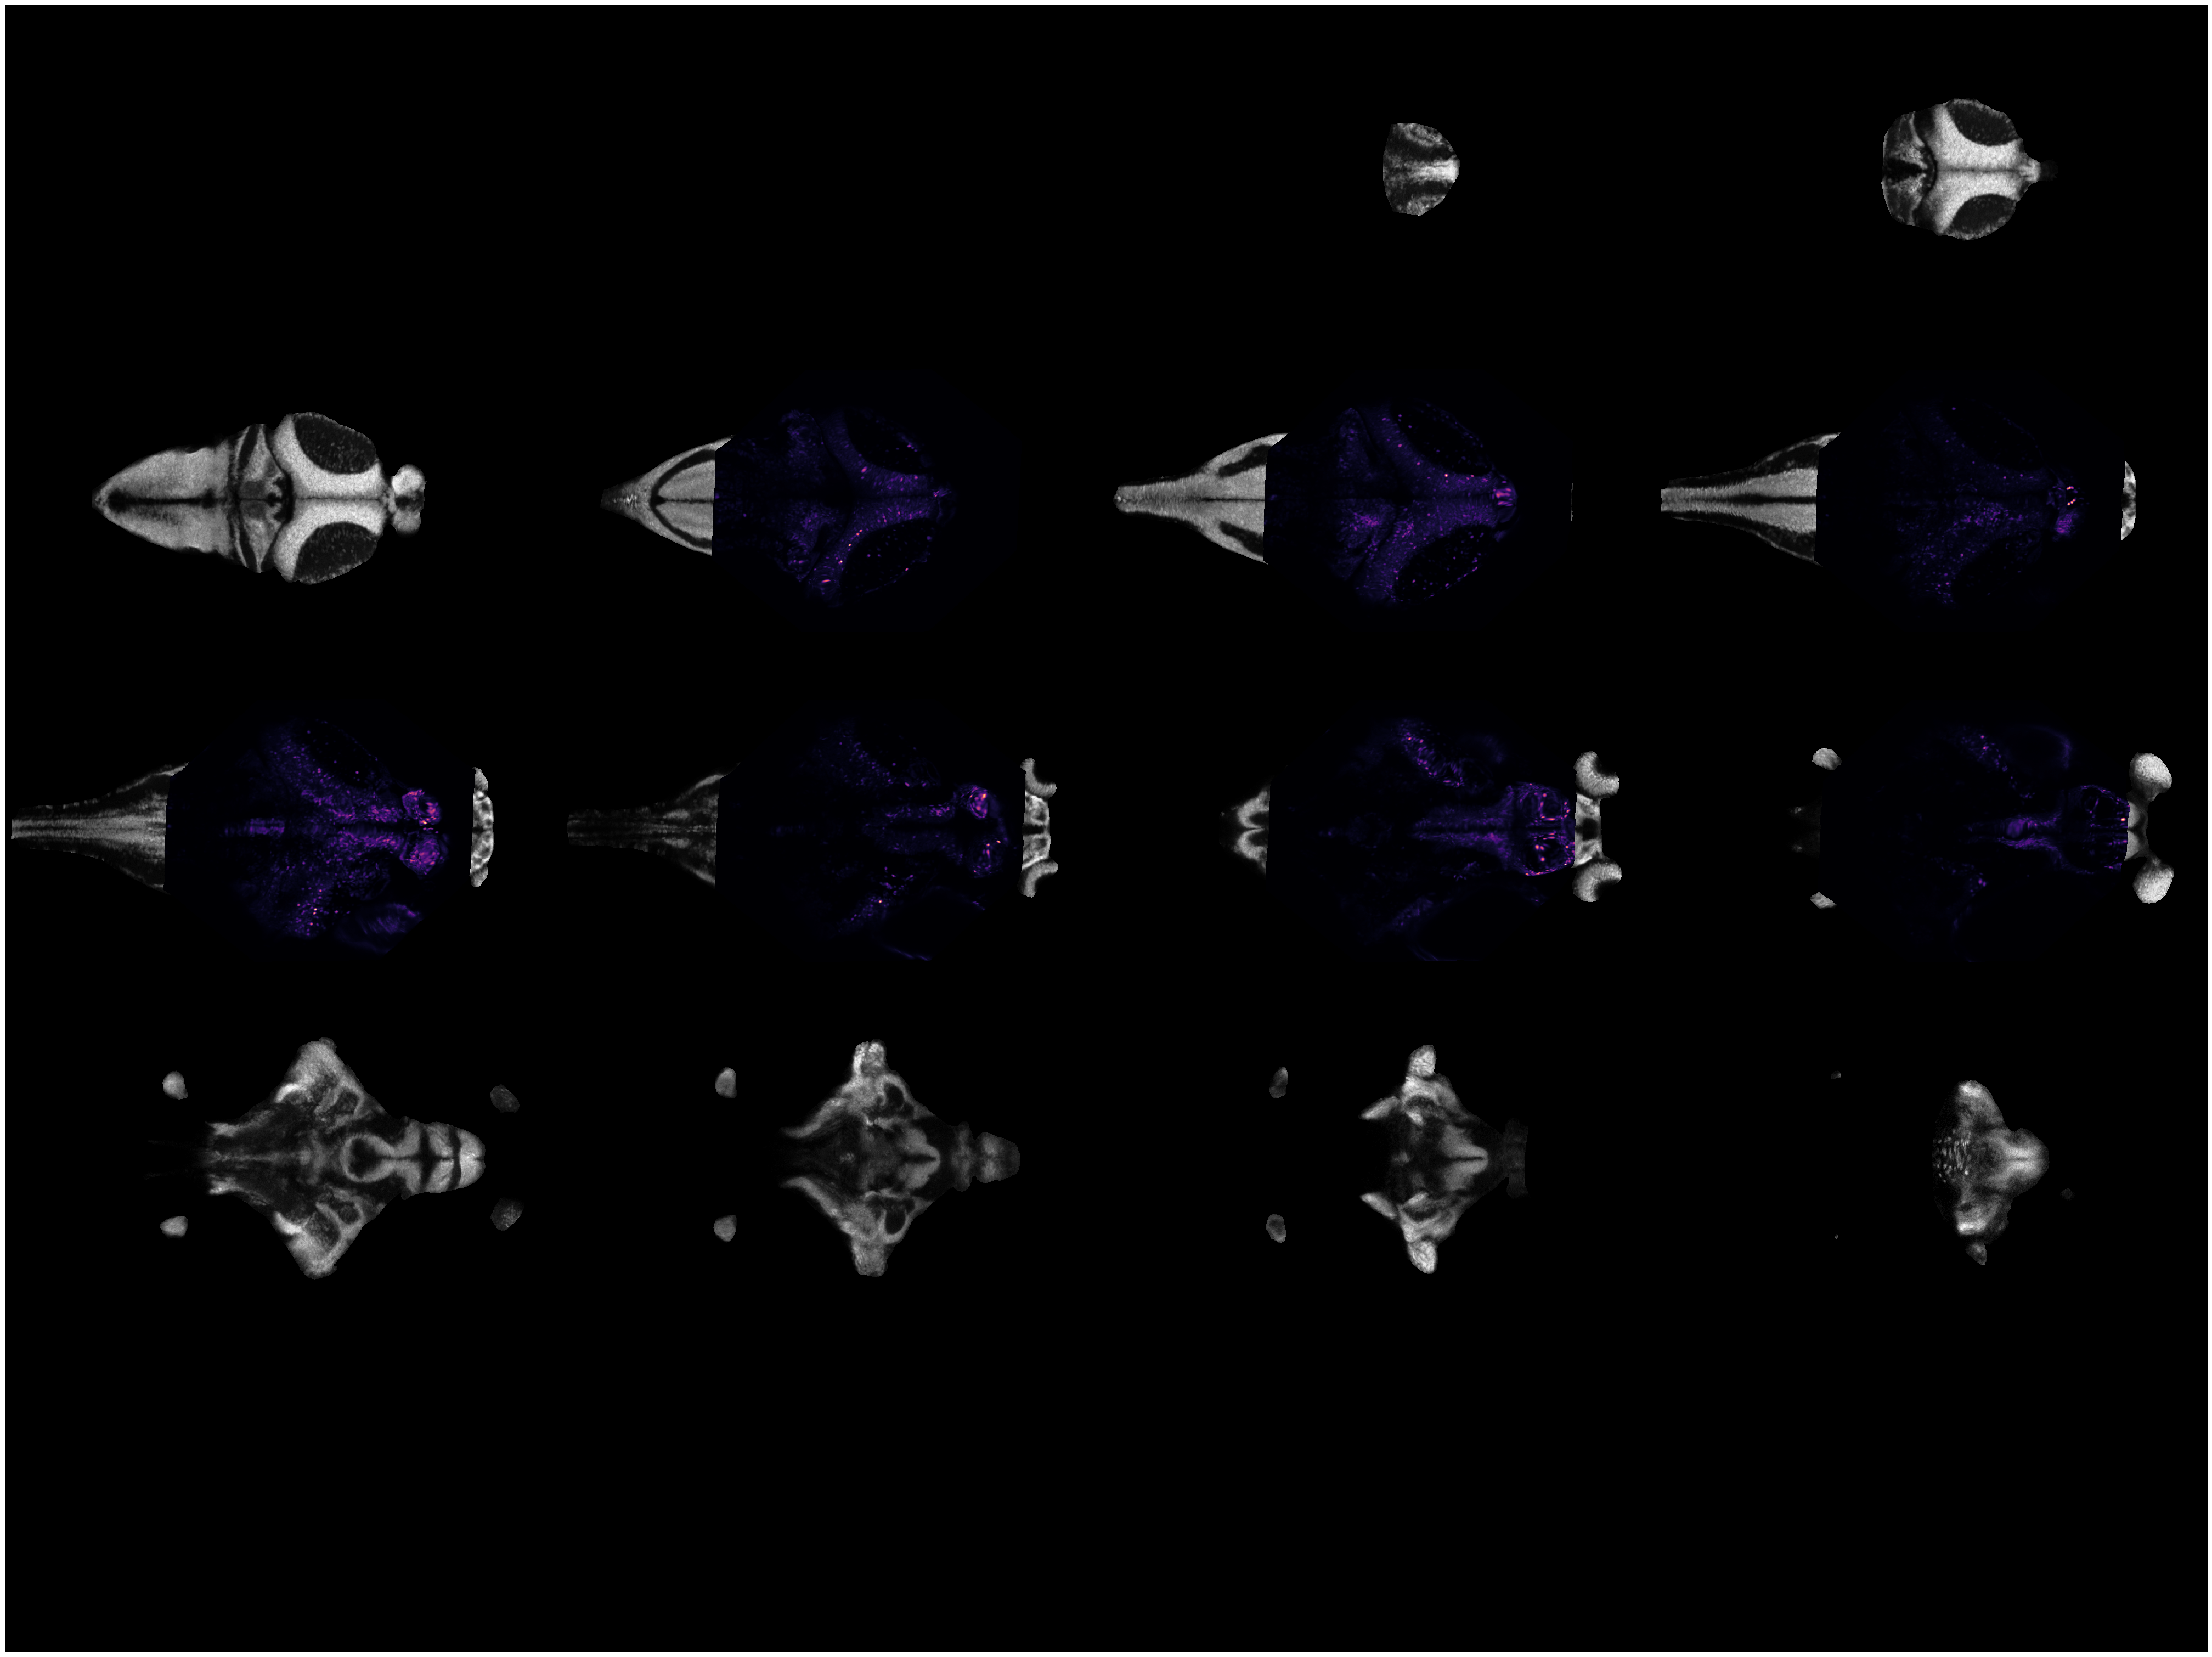

In [15]:
#Inspect registration
rfn.fishplot(zbb,f_prac['warpedmovout'], orient = 'axial', al = 1)

# Apply registration to coordinates

<Figure size 1000x1000 with 0 Axes>

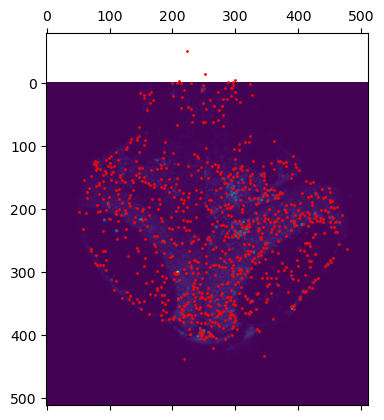

In [16]:
#Rotate coordinates onto image and visualise - preregistration
xyz = np.load(coordlist[0])
origin = 512/2,512/2
angle = int(meanimglist[0][meanimglist[0].find('stack')+6:meanimglist[0].find('deg')])

dotproduct = np.zeros((xyz.shape[0], 2))
for i in range(xyz.shape[0]):
    dotproduct[i] = rfn.rotate_point(origin,xyz[i,:2], angle)

dp = np.column_stack((dotproduct, xyz[:,2]))
dp = dp.astype(int)

#------------------------
plane_num= 2
plt.figure(figsize = (10,10))
plt.matshow(f[:,:,plane_num])
loc = np.where(dp[:,2] == plane_num)
plt.scatter(dp[:,0][loc],dp[:,1][loc], s = 1, c = 'red', alpha = 1)
plt.show()

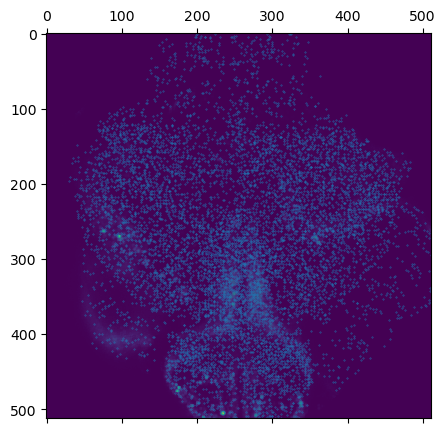

In [17]:
#Create labelled image - remove outlier cells
#Plot labelled image across all planes - preregistration check

ant_img = f
lab_img = ant_img*0
mult = dp[:,0]*dp[:,1]
zer = np.where(mult <= 0 )
out_x = np.where(dp[:,0] > 511)
out_y = np.where(dp[:,1] > 511)
comb = []
comb = np.append(zer, np.append(out_x, out_y))
dp_n = np.delete(dp, comb, 0)

#This will create an image of the xy coordinates in the same space as the input ants image. Visualise with plot
count=1
for i in range(dp_n.shape[0]):
    lab_img[dp_n[i][1], dp_n[i][0], dp_n[i][2]] = int(count)
    count+=1
    
    
plot = np.zeros((lab_img[:,:,0].shape))
for i in range(10):
    plot +=lab_img[:,:,i]
    
    
#Check that the transformation has worked
num = 9
fig,axarr = plt.subplots(figsize = (5,5))
axarr.matshow(ant_img[:,:,num])
axarr.scatter(np.where(plot > 0)[1],np.where(plot > 0)[0], s = 0.1)
plt.show()

In [19]:
#Apply transformation to labelled image
f_synra_points = ants.apply_transforms(zbb, lab_img, f_prac['fwdtransforms'], interpolator='nearestNeighbor')
full_plot = np.zeros((f_synra_points[:,:,0].shape))
for i in range(420):
    full_plot +=f_synra_points[:,:,i]

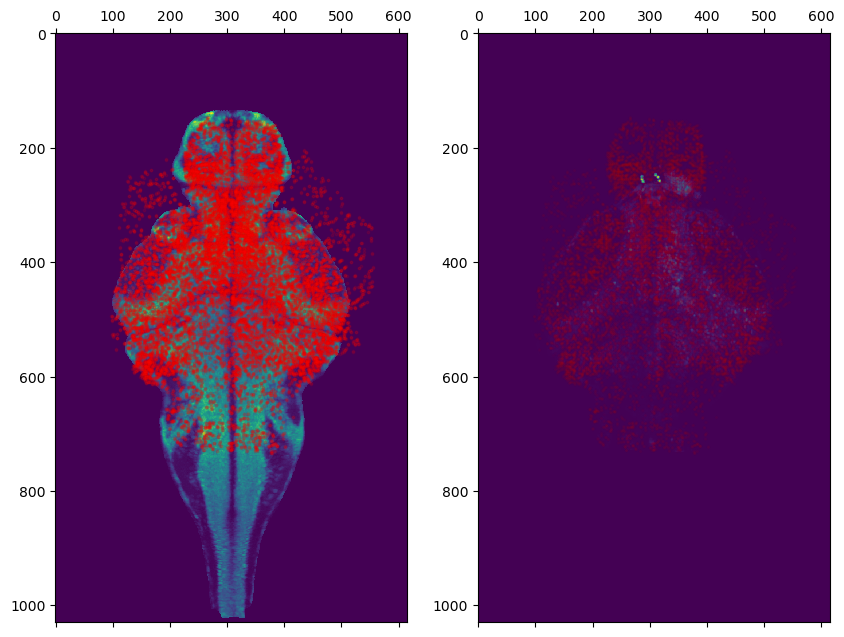

In [23]:
#Check that all neurons are overlaid correctly over brain - postregistration
xnum = 150
fin_plot = full_plot
curr_warped = f_prac['warpedmovout']
curr_points = f_synra_points
old_points = dp_n

fig,axarr = plt.subplots(1,2, figsize = (10,10))
axarr[0].matshow(zbb[:,:,xnum])
axarr[0].scatter(np.where(fin_plot > 0)[1],np.where(fin_plot > 0)[0], s = 3, alpha = 0.1, c = 'red')
axarr[1].matshow(curr_warped[:,:,xnum])
axarr[1].scatter(np.where(fin_plot > 0)[1],np.where(fin_plot > 0)[0], s = 2, alpha = 0.02, c = 'red')
plt.show()


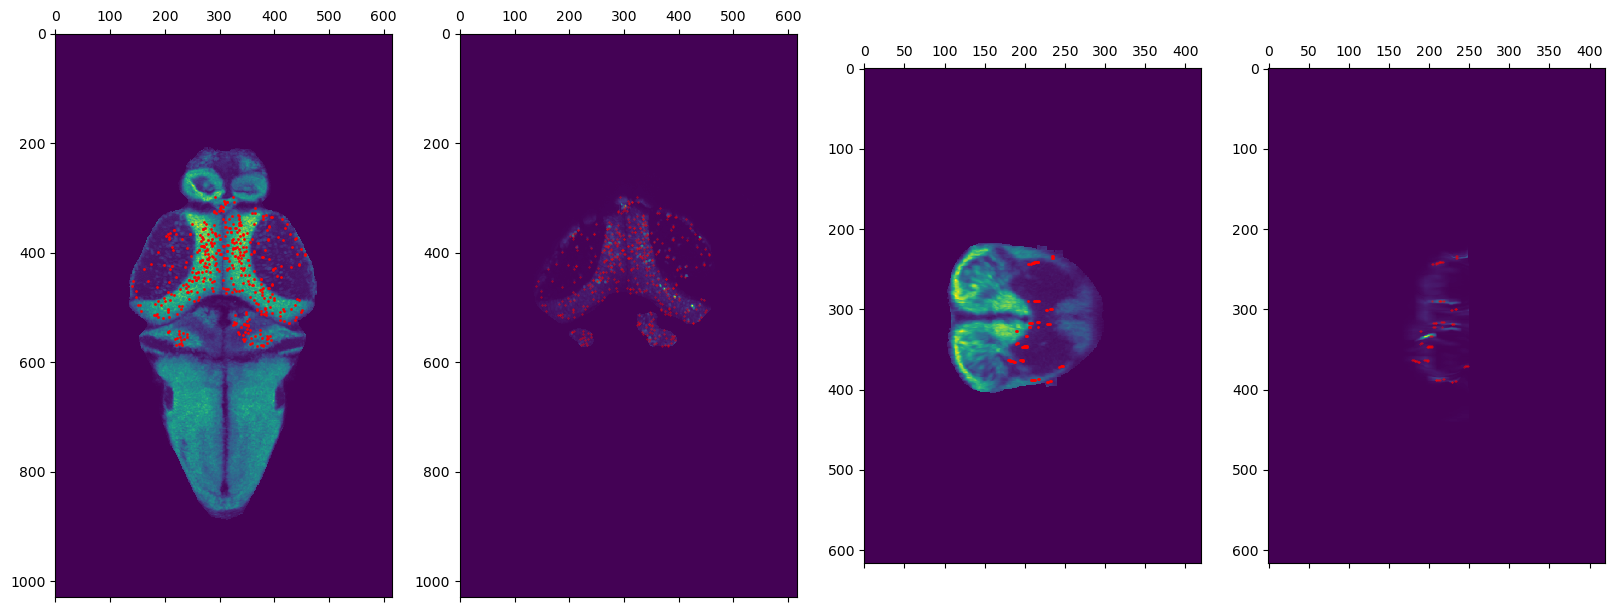

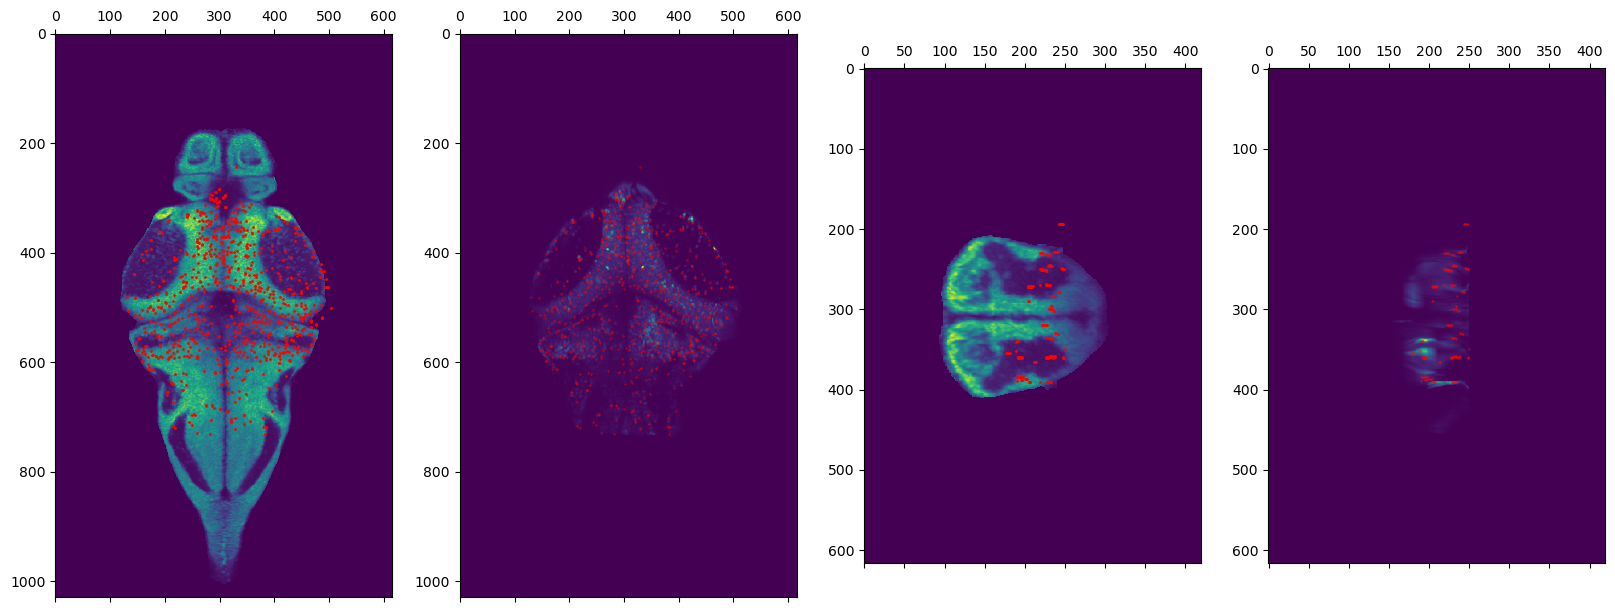

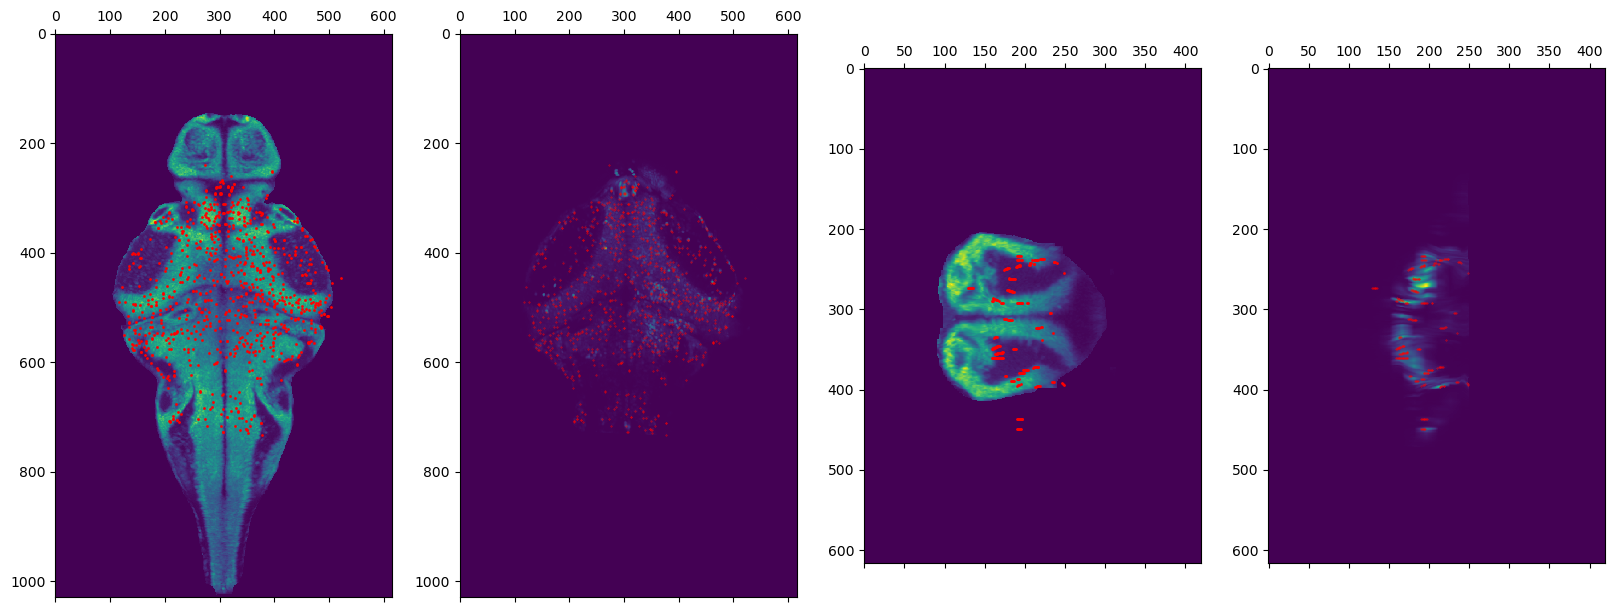

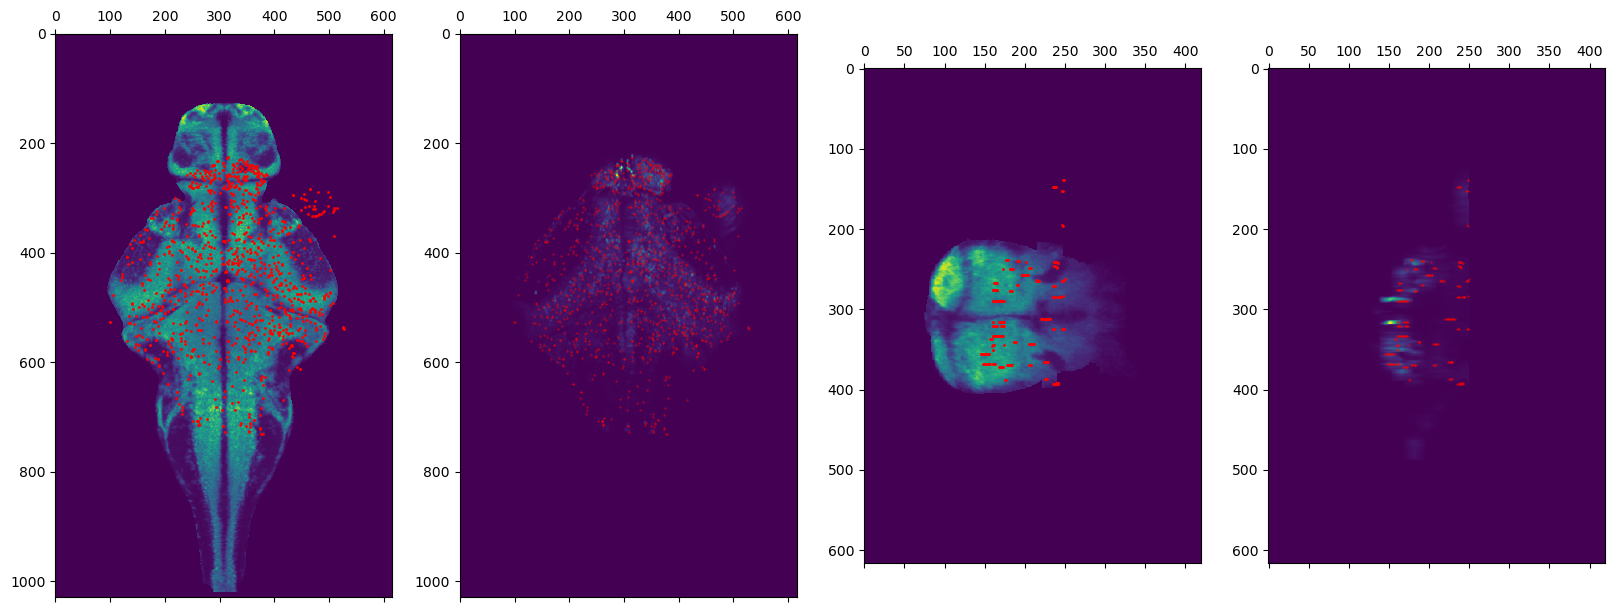

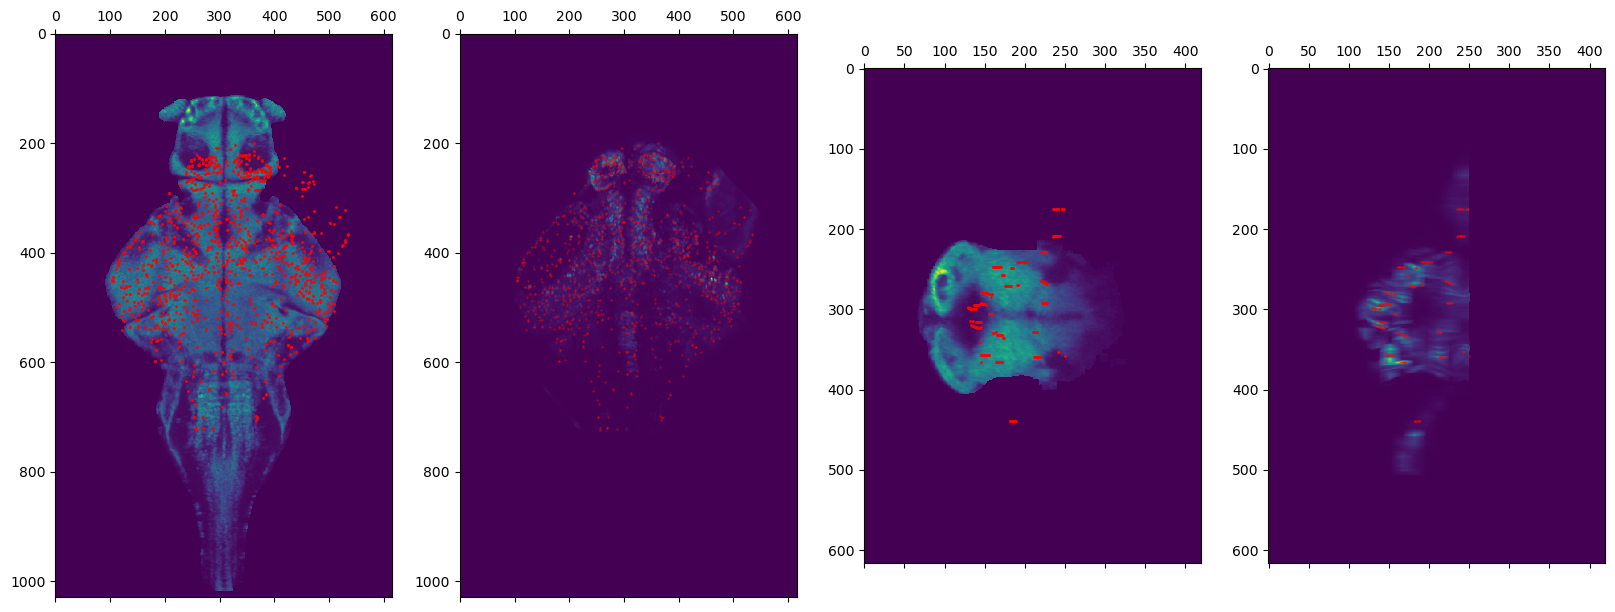

In [24]:
#Check neurons plane by plane
znumlist = np.arange(100, 200, 20)
xnumlist = np.arange(200, 300,20)

for num in range(len(znumlist)):
    fig,axarr = plt.subplots(1,4, figsize = (20,20))
    axarr[0].matshow(zbb[:,:,znumlist[num]])
    axarr[0].scatter(np.where(curr_points[:,:,znumlist[num]] > 0)[1],np.where(curr_points[:,:,znumlist[num]] > 0)[0], s = 1, c = 'red')
    axarr[1].matshow(curr_warped[:,:,znumlist[num]])
    axarr[1].scatter(np.where(curr_points[:,:,znumlist[num]] > 0)[1],np.where(curr_points[:,:,znumlist[num]] > 0)[0], s = 0.1, c = 'red')
    axarr[2].matshow(zbb[xnumlist[num],:,:])
    axarr[2].scatter(np.where(curr_points[xnumlist[num],:,:] > 0)[1],np.where(curr_points[xnumlist[num],:,:] > 0)[0], s = 1, c = 'red')
    axarr[3].matshow(curr_warped[xnumlist[num],:,:])
    axarr[3].scatter(np.where(curr_points[xnumlist[num],:,:] > 0)[1],np.where(curr_points[xnumlist[num],:,:] > 0)[0], s = 0.1, c = 'red')
    plt.show()

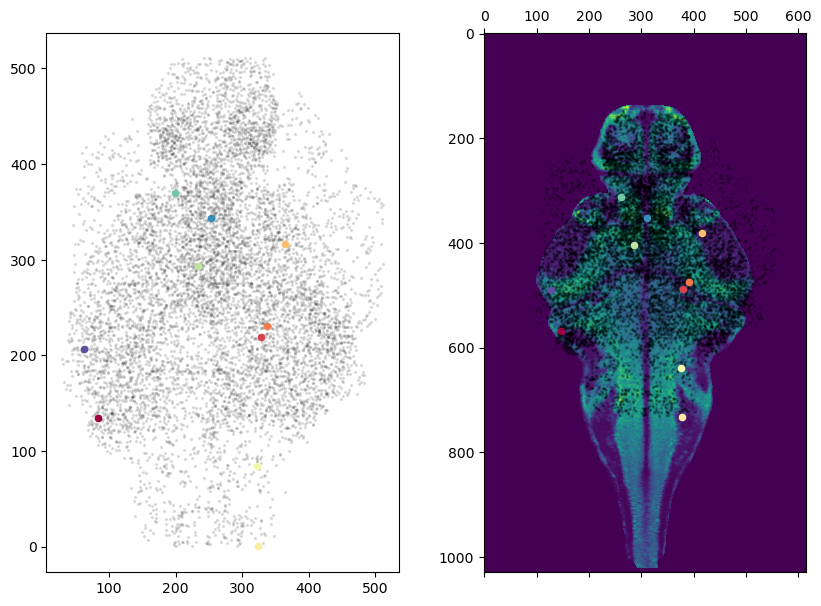

In [25]:
#Check that cell ids are correctly retained
import random
from matplotlib import cm
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

n_cells = 10
xnum = 150
fig,axarr = plt.subplots(1,2,figsize = (10,7))
axarr[0].scatter(old_points[:,0],old_points[:,1], s = 2, c = 'k', alpha = 0.1)
axarr[1].matshow(zbb[:,:,xnum])
axarr[1].scatter(np.where(fin_plot > 0)[1],np.where(fin_plot > 0)[0], s = 1, alpha = 0.1, c = 'k')

colors  = cm.Spectral(np.linspace(0,1,n_cells))
for i in range(n_cells):
    choose = random.randint(1,len(old_points)+1)
    all_loc = np.where(curr_points[:] == choose)
    mean_loc = np.mean(all_loc[0]), np.mean(all_loc[1])
    axarr[0].scatter(old_points[:,0][choose-1],old_points[:,1][choose-1], s = 20, c = colors[i], alpha = 1)
    axarr[1].scatter(mean_loc[1],mean_loc[0], s = 20, c = colors[i], alpha = 1)
plt.show()

# Assign atlas labels

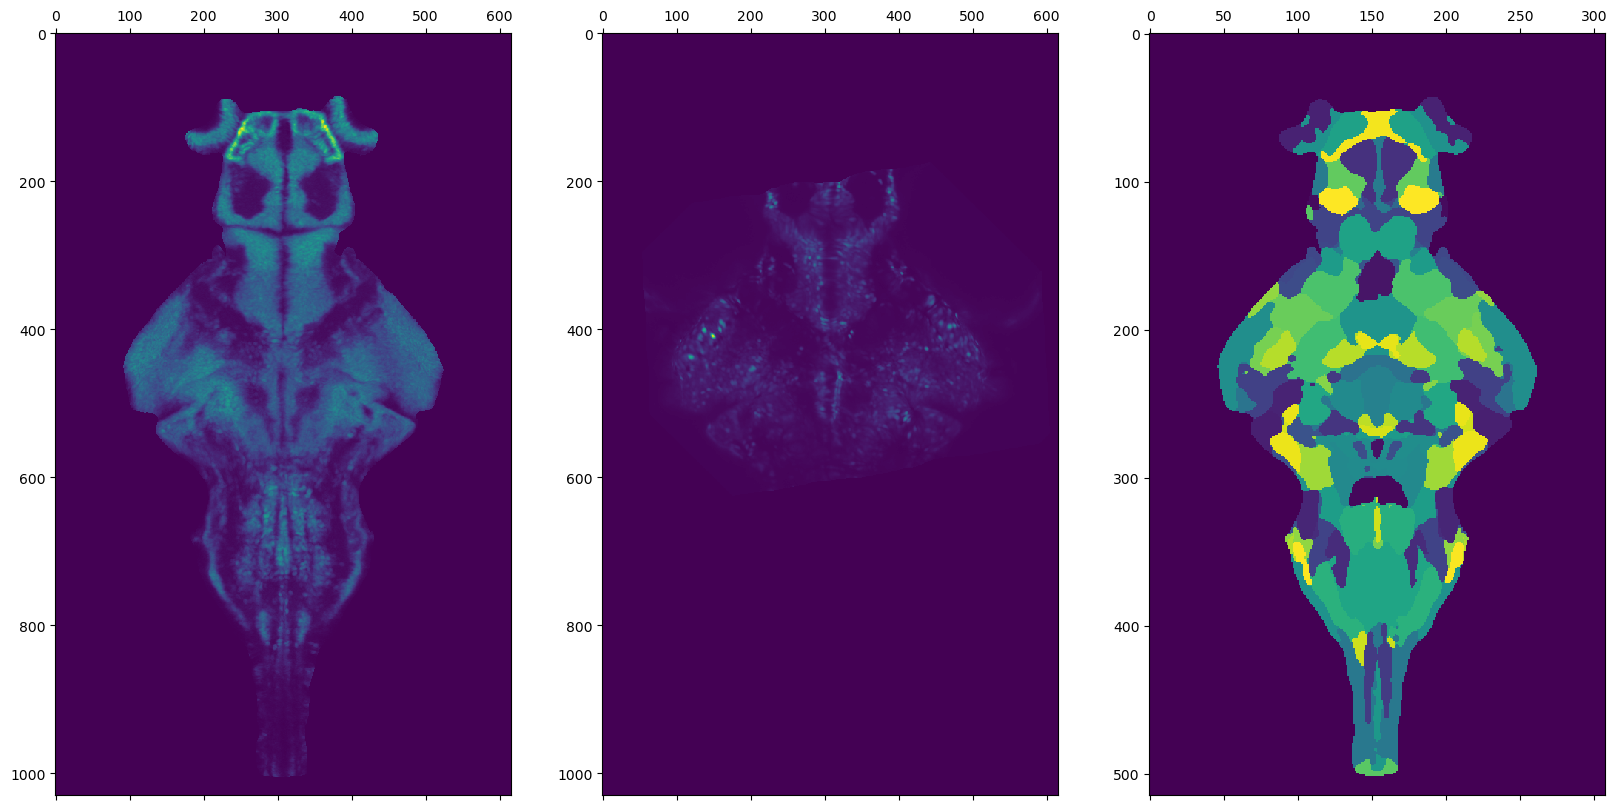

In [81]:
#Check that the registration has worked
plane_num = 200
fish = fish2ref_synra['warpedmovout']
fig,axarr = plt.subplots(1,3, figsize = (20,20))
axarr[0].matshow(zbb[:,:,plane_num])
axarr[1].matshow(fish[:,:,plane_num])
axarr[2].matshow(label[:,:,np.int(plane_num/2)])
plt.show()

# RIP ----- Code Graveyard

In [ ]:
# Manually generate mean img
#----------------------------------------------------------------------
import random as rand
import re

# Generate mean image
#-----------------------------------------------------------------------------------
import random as rand
import re

nrand = 200  #take nrand random images
planes = 10
planelist = list(range(planes))
regvectorlist = list(range(nrand))
regstack = np.zeros((nrand, 262144)) #pixels per image
planecorrvalues = list(range(planes))

#Split into planes
#-----------------------------------------------------------------------------------
for x in range(planes):
    rdm = rand.sample(range(x+1, int(len(tifflist)/10), 10), nrand)
    planelist[x] = rdm  
    
# Find 20 most correlated images per plane 
#-----------------------------------------------------------------------------------
    for i in range(nrand):
        howmany0s = 6 - len(str(planelist[x][i]))
        tiffname = str(planelist[x][i])
        tiffname = tiffname.zfill(len(tiffname) + howmany0s)
        regarray = io.imread(Fmut + '/im_' + tiffname + '.tif')
        regvectorlist[i] = np.concatenate(regarray)   #make into vector 
        regstack [i,:] = regvectorlist[i]
    
    planecorrvalues[x] = np.corrcoef(regstack)

    
#remove self correlated values #python function
#--------------------------------------------------
for x in range(planes):    
    for j in range(planecorrvalues[x].shape[0]):
        for i in range(planecorrvalues[x].shape[0]):
            if planecorrvalues[x][i][j] >0.9:
                planecorrvalues[x][i][j] = 0
                
                
#returns highest 40 correlation values 
#----------------------------------------------------------------
top = []
wll = list(range(planes))
w2ll = list(range(planes))

for x in range(planes): 
    top = planecorrvalues[x] > np.percentile(planecorrvalues[x],99.8) 
    wherelist = list(range(len(top)))
    where2list = list(range(len(top)))
    counter = 0
    
    for j in range(planecorrvalues[x].shape[0]):
        if np.where(top[j] == True)[0].any() > 0:
            wherelist[counter] = planelist[x][j]
            where2list[counter] = np.where(top[j] == True)[0]
            counter+= 1 
    wll[x] = wherelist
    w2ll[x] = where2list

    
    
#initialise vector to fill with frame values
#----------------------------------------------
allimv = np.zeros((planes, np.sum(top)))

for x in range(planes): 
    
    #find final frames that are most correlated
    #----------------------------------------------
    for y in range(allimv.shape[1]):
        vector = np.hstack(w2ll[x])
        allimv[x,y] = planelist[x][vector[y]] #output is array of all most correlated frames per plane - find unique values and average them
        
#plot mean image
#----------------------------------
meanlist = list(range(planes))

for x in range(planes):
    fillme = np.unique(allimv[x])
    means = list(range(len(fillme)))
    for i in range(len(fillme)):
        howmany0s = 6 - len(str(int(fillme[i])))
        tiffname = str(int(fillme[i]))
        tiffname = tiffname.zfill(len(tiffname) + howmany0s)
        loadme = io.imread(Fmut + '/im_' + tiffname + '.tif')
        means[i] = loadme
        
    meanlist[x] = np.mean(means, axis = 0)
    
degree = 9.6
rotimglist = list(range(len(meanlist)))

f, axarr = plt.subplots(2,5, sharey = True, sharex = True, figsize = (40,30))
axarr = axarr.flatten()

for i in range(len(meanlist)):
    rotated_img = ndimage.rotate(meanlist[i], degree*60)
    
    rotimglist[i] = rotated_img
    axarr[i].matshow(rotimglist[i])
    
f.tight_layout()